## Simple image classifier for Tom & Jerry images using AlexNet architecture


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch.nn.functional as F
import torch
from torchvision import transforms
from torchinfo import summary
from PIL import Image
from model import Classifier

### Print the model summary
This part visualizes the architecture of the used model and shows the number of parameters.

In [2]:
model = Classifier(num_classes=4)
summary(model=model, input_size=(1, 3, 227, 227))

Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [1, 4]                    --
├─Sequential: 1-1                        [1, 256, 6, 6]            --
│    └─Conv2d: 2-1                       [1, 64, 55, 55]           23,296
│    └─ReLU: 2-2                         [1, 64, 55, 55]           --
│    └─MaxPool2d: 2-3                    [1, 64, 27, 27]           --
│    └─Conv2d: 2-4                       [1, 256, 27, 27]          409,856
│    └─ReLU: 2-5                         [1, 256, 27, 27]          --
│    └─MaxPool2d: 2-6                    [1, 256, 13, 13]          --
│    └─Conv2d: 2-7                       [1, 384, 13, 13]          885,120
│    └─ReLU: 2-8                         [1, 384, 13, 13]          --
│    └─Conv2d: 2-9                       [1, 384, 13, 13]          1,327,488
│    └─ReLU: 2-10                        [1, 384, 13, 13]          --
│    └─Conv2d: 2-11                      [1, 256, 13, 13]       

### Load the saved metrics (array of values of train loss and train accuracy) from train.py file

In [3]:
data = np.load("metrics.npz")
train_losses = data['train_losses']
train_accuracies = data['train_accuracies']

### Plot metrics for model evaluation

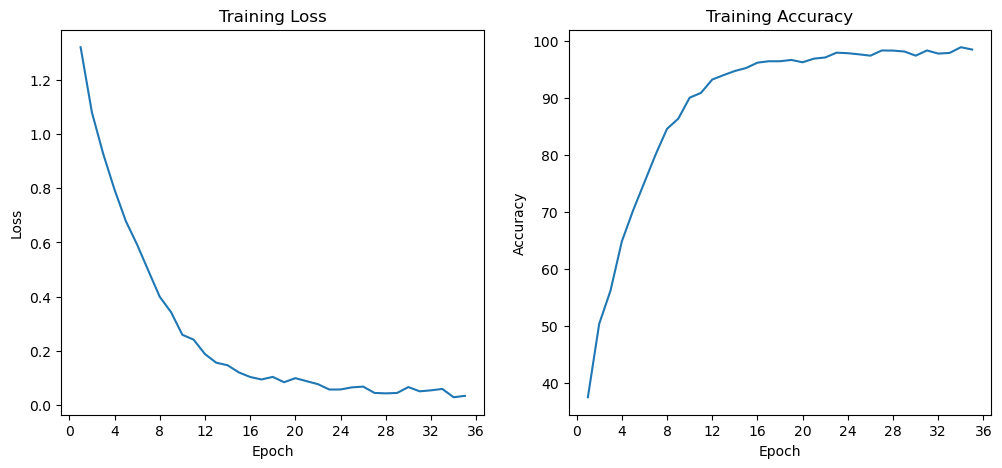

In [4]:
epoch = [i + 1 for i in range(35)]
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot loss
axes[0].plot(epoch, train_losses)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Plot accuracy
axes[1].plot(epoch, train_accuracies)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training Accuracy')
axes[1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.show()

### Load and make inference with the trained parameters

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Classifier()
model.to(device)

# Load saved parameters
model.load_state_dict(torch.load("tomjerry.pth", weights_only=True))
model.eval()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr = 1e-4
)

# Define the same transformation as when training
transform = transforms.Compose([transforms.Resize((227, 227)),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.5, 0.5, 0.5],
                                                     [0.5, 0.5, 0.5])])

### Data to predict
Here I already created a folder containing the images used for making inference.


The block of code below simply iterate through this folder and plot the image as well as the predicted label made by the trained model.

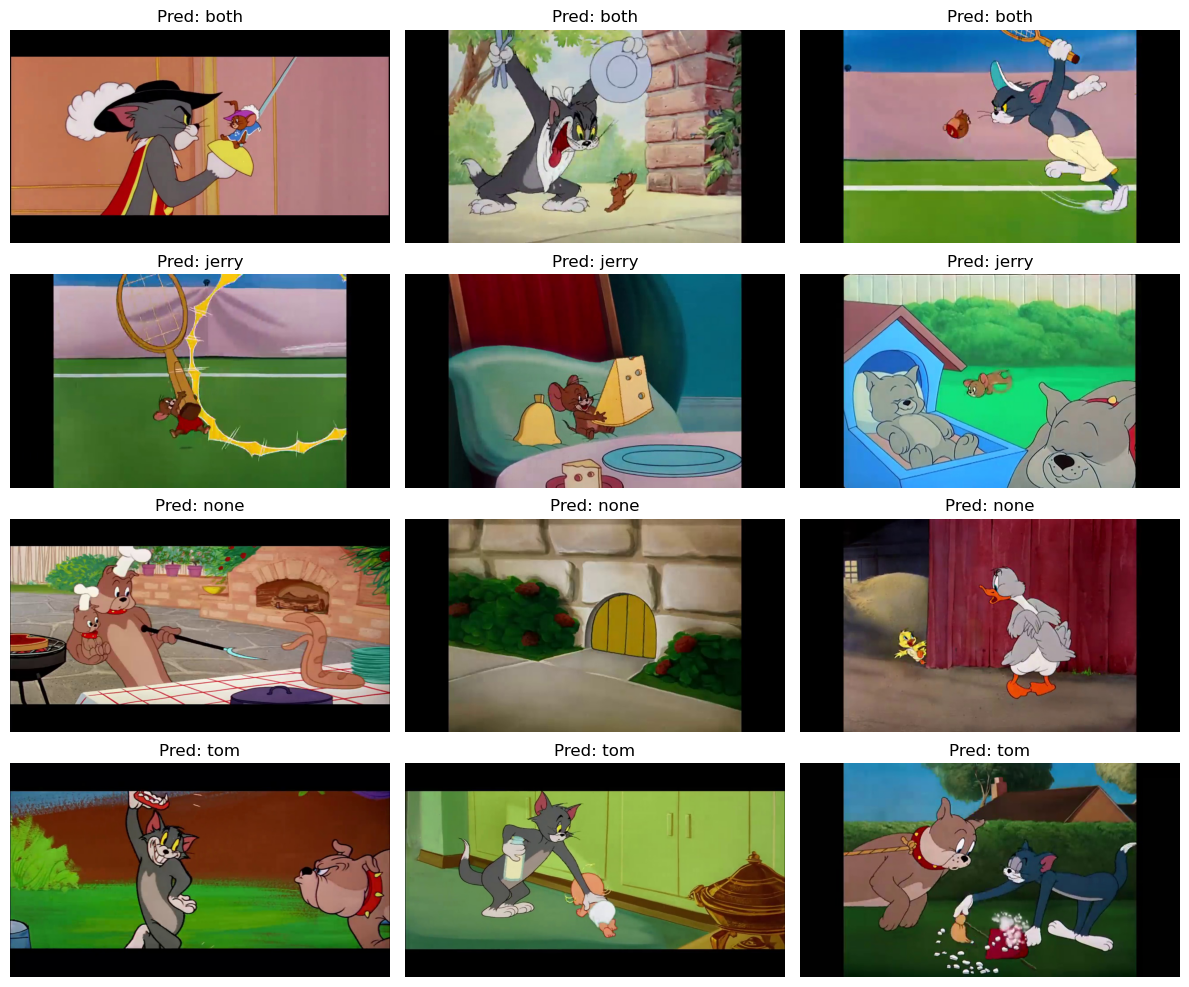

In [23]:
fig, axes = plt.subplots(4, 3, figsize=(12, 10))
axes = axes.flatten()
index = 0

directory = os.fsencode("test_img")

class_names = ['jerry', 'tom', 'none', 'both']


for file in sorted(os.listdir(directory)):
    img = Image.open(os.path.join(directory, file)).convert("RGB")
    img_np = np.array(img)
    img = transform(img)
    img = img.unsqueeze(0)
    img = img.to(device)
    
    # Code to predict on single image
    with torch.inference_mode():
        res = model(img)
        prob = F.softmax(res, dim=1)
        preds = prob.argmax(dim=1)
       
        axes[index].imshow(img_np)
        axes[index].set_title(f"Pred: {class_names[preds.item()]}")
        axes[index].axis('off')
        index+=1

plt.tight_layout()
plt.show()
    


